## Use numerov to generate Eigenfunctions for Pöschl-Teller potential

In [2]:

import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.linalg import eig
import numpy as np

# Import the prepared functions
from numerov import solve_schroedinger, symmetric

Define potential

In [3]:
def poeschl_teller(xs, lam=5, a=1):
    return -lam * (lam + 1) * a**2 / (2 * np.cosh(a * xs) ** 2)

In [4]:

# Input parameters
N_single = 20000  # Number of grid points
xmax_single = 25  # Extent of the grid
lam = 5

# Preparation of the grid
xg = np.linspace(0, xmax_single, N_single)
h = xg[1] - xg[0]

# ...and the potential
V = poeschl_teller(xg, lam=lam)

In [ ]:
# why do only negative test energies give the right energies?

def create_wf(k, gerade, V, Etry=-1):
    u, E, dE, n_nodes = solve_schroedinger(V, k=k, gerade=gerade, h=h, Etry=Etry)
    print(n_nodes)
    print(E)
    psi0 = symmetric(u, gerade=gerade)
    psi0 /= np.sqrt(np.trapezoid(psi0 * psi0, dx=h))
    return psi0, E

ao =[]
k = 0
for i in range(lam): 
    gerade = (i%2 == 0)
    ao.append(create_wf(k, gerade, V))
    if i%2 == 1:
        k +=1
    
    

0
-12.499999995300183
0
-7.9999999940671565
1
-4.499999996481058
1
-1.99999999869139
2
-0.4999999997958626


Plot Potential

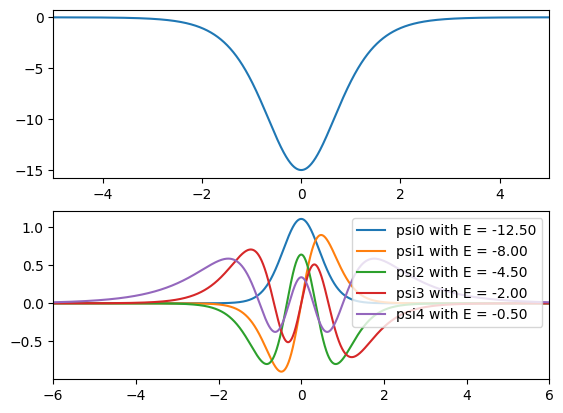

In [6]:
V_plot = symmetric(V, gerade=True)
xg = symmetric(xg, gerade=False)

fig, axs = plt.subplots(2, 1, sharex=False)

axs[0].plot(xg, V_plot)

for i,orb in enumerate(ao):
    axs[1].plot(xg, orb[0], label=f"psi{i} with E = {orb[1]:.2f}")

axs[0].set_xlim((-5, 5))
axs[1].set_xlim((-6, 6))

plt.legend(loc='upper right')

## LCAO for multiple potential wells
- set up potential in space
- set up basis functions in space (2D array, one dimension is the index of ao, the other is the function values)
- calculate H in ao basis
- calculate S in ao basis

set up potential


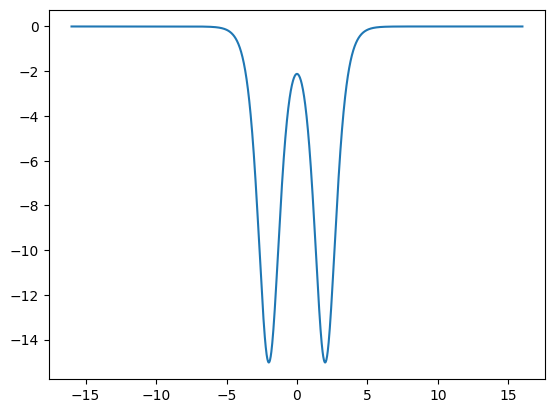

In [27]:
d = 4
N_single = 2000
n_centers = 2
x_max = n_centers * d * 2
x_space = np.linspace(-x_max, x_max, N_single)

def multiwell_pot(pot_funct, n_centers, d, x):
    V_tot = np.zeros((N_single))
    gerade = (n_centers%2 == 0)
    if gerade:
        for i in range(int(n_centers/2)):
            V_tot += pot_funct(x - (i+0.5)*d)
            V_tot += pot_funct(x + (i+0.5)*d)
    if not gerade:
        V_tot += pot_funct(x)
        for i in range(1,int(n_centers//2+1)):
            V_tot += pot_funct(x + i*d)
            V_tot += pot_funct(x - i*d)


    return V_tot

def half_multiwell(pot_funct, n_centers, d, x_half):
    V_tot = np.zeros((N_single))
    gerade = (n_centers%2 == 0)
    if gerade:
        for i in range(int(n_centers/2)):
            V_tot += pot_funct(x_half + (i+0.5)*d)
    if not gerade:
        V_tot += pot_funct(x_half)
        for i in range(1, int(n_centers//2+1)):
            V_tot += pot_funct(x_half + i*d)
    return V_tot




pot = multiwell_pot(poeschl_teller, n_centers, d, x_space)
plt.plot(x_space, pot)

set up basis functions

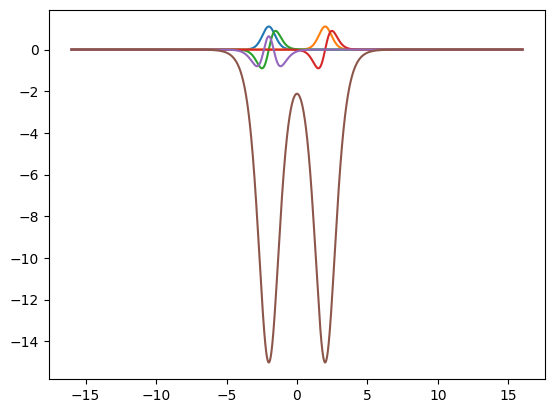

In [28]:
def move_center(psi, d, x, xg=xg):
    xg = xg + d
    spline = UnivariateSpline(xg, psi, s=0)
    psi_shift = spline(x)
    return psi_shift


n_states = 3  # number of atomic states used for every center
n_basis = n_states * n_centers

phi_ao = np.zeros((n_states, n_centers, np.shape(x_space)[0]))

gerade = (n_centers%2 == 0)
for i in range(n_states):
    psi = ao[i][0]
    count = 1
    if gerade:
        for j in range(n_centers):
            abs_shift = j // 2
            count *= -1
            phi_ao[i,j] = move_center(psi, (abs_shift + 0.5) * d * count, x_space)
    if not gerade:
        for j in range(n_centers):
            count *= -1
            if j == 0:
                phi_ao[i,j] = move_center(psi, 0, x_space)
            else:
                abs_shift = (j+1) // 2
                phi_ao[i,j] = move_center(psi, abs_shift * d * count, x_space)


phi_ao = np.reshape(phi_ao, (n_basis, np.shape(x_space)[0]))

plt.plot(x_space, phi_ao[0])
plt.plot(x_space, phi_ao[1])
plt.plot(x_space, phi_ao[2])
plt.plot(x_space, phi_ao[3])
plt.plot(x_space, phi_ao[4])
plt.plot(x_space, pot)
plt.show()

calculate S matrix

In [29]:
def inner_prod(psi1, psi2, x_space):
    h = x_space[1]- x_space[0]
    return np.trapezoid(psi1 * psi2, dx=h)

def calc_S(phi_ao, x_space):
    n_basis = np.shape(phi_ao)[0]
    S = np.zeros((n_basis, n_basis))

    for j in range(n_basis):
        for i in range(n_basis): 
            S[i,j] = inner_prod(phi_ao[i], phi_ao[j], x_space)
    return S


Calculate H matrix

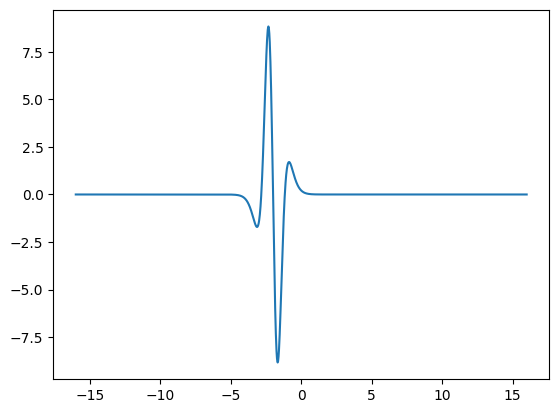

In [30]:
# why are there nonzero values at the boundaries?
def grid_laplacian(wf, x_space):
    h = x_space[1] - x_space[0]
    laplacian = np.zeros(np.shape(wf))
    wf = np.pad(wf, pad_width=1, mode="constant", constant_values=0)
    laplacian = (wf[:-2] + wf[2:] - 2 * wf[1:-1])/h**2
    return laplacian
      
def apply_hamiltonian(pot, phi, x_space):
    H = -0.5 * grid_laplacian(phi, x_space) + (pot * phi)
    return H

def calc_H(pot, phi_ao, x_space):
    n_basis = np.shape(phi_ao)[0]
    H = np.zeros((n_basis, n_basis))

    for j in range(n_basis):
        for i in range(n_basis): 
            ket = apply_hamiltonian(pot, phi_ao[j], x_space)
            H[i,j] = inner_prod(phi_ao[i], ket, x_space)
    return H

plt.plot(x_space, grid_laplacian(phi_ao[2], x_space))

Solve generalized eigenvalue problem

In [31]:
H = calc_H(pot, phi_ao, x_space)
S = calc_S(phi_ao, x_space)

E, c_vec = eig(H, S)
E = np.real(E)
print(np.shape(c_vec))
print(E)

(6, 6)
[-12.52539076 -12.52536464  -4.54832105  -4.60167029  -8.04221787
  -8.04001431]


In [ ]:
mol_orb = c_vec.T @ phi_ao

(6, 2000)


In [35]:
show_orb = [0, 1, 2, 3]
for i in show_orb:
    plt.plot(x_space, mol_orb[i] + E[i], label=f"{E[i]:.2f}")
plt.plot(x_space, pot, ls="--")
plt.legend()

IndexError: invalid index to scalar variable.

## Numerov for the combined system

In [34]:
x_half = np.linspace(0, x_max, N_single)
pot_half = half_multiwell(poeschl_teller, n_centers,d, x_half)
psi, E = create_wf(k=1, gerade=False, Etry=-70, V=pot_half)

0
-1.3917136981461466e-14
